# To-Dos: 

In [1]:
## Datensatz 'San Francisco Crime Classification' von Kaggle
## Datensatzbeschreibung:
# Datum                         - Zeitpunkt der Straftat
# Kategorie                     - Kategorie der Straftat (nur in Trainingsdaten), Zielvariable
# Beschreibung                  - detaillierte Beschreibung der Straftat (nur in Trainingsdaten)
# Tag der Woche
# 'District' der Polizeistation - Name des 'Districts' der Polizeistation
# Auflösung                     - Ergebniss der Straftat
# Adresse                       - geschätzte Adresse der Straftat
# X                             - Long
# Y                             - Lat

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
# Import der Pakete
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [4]:
# Einlesen der Trainings- und Testdaten
#train = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/train.csv")
#test  = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/test.csv")

In [5]:
# Pauls Kasten
#train = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/train.csv")
#test  = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/test.csv")

In [6]:
# Noah Kasten Lokal
#train = pd.read_csv(r'N:\FC_0_0_4\008_persoenliche_Arbeitsordner\Pannicke\Uni\Data Mining\data\train\train.csv')
#test = pd.read_csv(r"N:\FC_0_0_4\008_persoenliche_Arbeitsordner\Pannicke\Uni\Data Mining\data\test\test.csv")
train = pd.read_csv(r"C:\Users\nopa9\Documents\Universität\Master - HTW\2. Semester\DS\data\SF-Project\train.csv")
test = pd.read_csv(r"C:\Users\nopa9\Documents\Universität\Master - HTW\2. Semester\DS\data\SF-Project\test.csv")

In [7]:
# Übersicht über Kopf der Trainingsdaten
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [8]:
# Datentypen ermitteln
train.dtypes
# Bis auf die Koordinaten sind alle Variablen objects
# Datum muss umgewandlet werden in date

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [9]:
train.shape
# Datensatz hat rund 900k Zeilen und 9 Spalten

(878049, 9)

# **Datenvorverarbeitung**
- Trennung der Datenspalte
- NA Behandlung
- Duplikate entfernen
- Einschränkung der Kategorien

In [10]:
## Datenformatierung - Dates
# Umwandeln in Datumformat
train['Dates'] = pd.to_datetime(train['Dates'])
# Trennung von Datum und Uhrzeit
train['Date'] = train['Dates'].dt.strftime('%Y-%m-%d')
train['Date'] = pd.to_datetime(train['Date'])

train['Time'] = train['Dates'].dt.strftime('%H:%M')
train['Hour'] = pd.to_datetime(train['Dates'], format='%H:%M').dt.hour
train['Minute'] = pd.to_datetime(train['Dates'], format='%M').dt.minute

In [11]:
# Jahr, Monat, Tag extrahieren
train['Year']  = train['Dates'].dt.strftime('%Y').astype(int)
train['Month'] = train['Dates'].dt.strftime('%m').astype(int)
train['Day']   = train['Dates'].dt.strftime('%d').astype(int)
train['WeekdayName'] = train['Dates'].dt.strftime("%A")

In [12]:
# Variable WeekOfYear anlegen
train['WeekOfYear'] = pd.to_datetime(train['Date']).dt.isocalendar().week.astype(int)

In [13]:
# Variable Dates löschen
# train = train.drop('Dates',axis=1)

In [14]:
## NA Behandlung
# Übersicht über NA in Spalten
train.isna().sum()
# keine NA's ersichtlich 

Dates          0
Category       0
Descript       0
DayOfWeek      0
PdDistrict     0
Resolution     0
Address        0
X              0
Y              0
Date           0
Time           0
Hour           0
Minute         0
Year           0
Month          0
Day            0
WeekdayName    0
WeekOfYear     0
dtype: int64

In [15]:
from shapely.geometry import  Point
import geopandas as gpd
#import geoplot as gplt
import shap
from sklearn.impute import SimpleImputer

C:\Users\nopa9\.conda\envs\SF-Project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


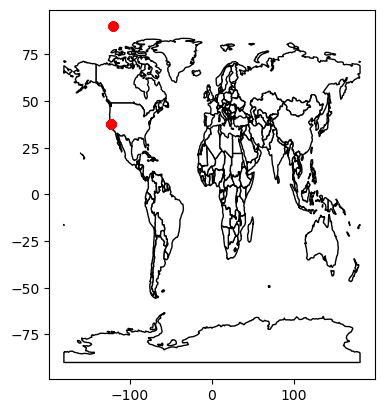

In [16]:
## Ausreißer, fehlerhafte Koordinaten 
# Lösung ist von Yannis Pappas (Kaggle)
# https://www.kaggle.com/code/yannisp/sf-crime-analysis-prediction
# Alternativlösungen benötigten kostenpflichtige geo API's

def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [17]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

67


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Time,Hour,Minute,Year,Month,Day,WeekdayName,WeekOfYear,Coordinates
671709,2005-11-02 20:30:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Wednesday,CENTRAL,NONE,BRENHAM PL / WASHINGTON ST,-120.5,90.0,2005-11-02,20:30,20,30,2005,11,2,Wednesday,44,POINT (-120.50000 90.00000)
759292,2004-08-04 01:12:00,WARRANTS,ENROUTE TO PAROLE OFFICER,Wednesday,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.5,90.0,2004-08-04,01:12,1,12,2004,8,4,Wednesday,32,POINT (-120.50000 90.00000)
798834,2004-01-24 14:00:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Saturday,CENTRAL,NONE,GREENWICH ST / THE EMBARCADERO NORTH ST,-120.5,90.0,2004-01-24,14:00,14,0,2004,1,24,Saturday,4,POINT (-120.50000 90.00000)
677260,2005-10-06 17:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Thursday,RICHMOND,NONE,AVENUE OF THE PALMS / EUCLID AV,-120.5,90.0,2005-10-06,17:30,17,30,2005,10,6,Thursday,40,POINT (-120.50000 90.00000)
674043,2005-10-21 10:15:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,2005-10-21,10:15,10,15,2005,10,21,Friday,42,POINT (-120.50000 90.00000)


'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


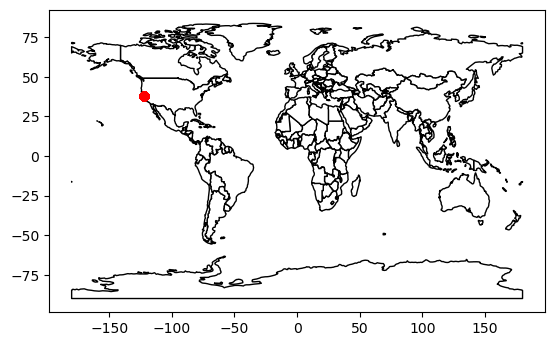

In [18]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
#test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    #test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        #test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [19]:
## Übersicht über Mengengerüst der Daten
# Ausgabe eindeutiger Werte für relevanten Spalten
train_uniq = train.loc[:,['Category','PdDistrict','Resolution','Address']]
for col in train_uniq:
  print(train_uniq[col].value_counts())

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

In [20]:
# Augenscheinlich keine fehlerhaften/uneindeutige Werte enthalten
# Bei Addresse sollte per Feature Importance die Relevanz für das Modell ermittelt werden,
# bevor man den Umfang an Werten genauer auf Fehler analysiert.

In [21]:
## Duplikate
# Anzahl der Duplikate
dup_rows = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows))

Anzahl an duplizierten Zeilen: 0


In [22]:
# Entfernen der Duplikate
train        = train.drop_duplicates()
dup_rows_new = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows_new))

Anzahl an duplizierten Zeilen: 0


In [23]:
# Entfernen von nicht nutzbaren Variablen 
train.drop(['Descript'],axis=1)

,Dates,Category,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Time,Hour,Minute,Year,Month,Day,WeekdayName,WeekOfYear
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23:53,23,53,2015,5,13,Wednesday,20
1,2015-05-13 23:53:00,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23:53,23,53,2015,5,13,Wednesday,20
2,2015-05-13 23:33:00,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13,23:33,23,33,2015,5,13,Wednesday,20
3,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13,23:30,23,30,2015,5,13,Wednesday,20
4,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13,23:30,23,30,2015,5,13,Wednesday,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003-01-06,00:15,0,15,2003,1,6,Monday,2
878045,2003-01-06 00:01:00,LARCENY/THEFT,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,2003-01-06,00:01,0,1,2003,1,6,Monday,2
878046,2003-01-06 00:01:00,LARCENY/THEFT,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,2003-01-06,00:01,0,1,2003,1,6,Monday,2
878047,2003-01-06 00:01:00,VANDALISM,Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003-01-06,00:01,0,1,2003,1,6,Monday,2


# **Feature Engineering**

In [24]:
#Sonnenauf -und untergänge in San Francisco auf monatlicher Basis
#sunset = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/SunsetSF.csv",delimiter =';')
#sunset['Month']=sunset['Month'].astype(int)


In [25]:
# Noah Kasten lokal
sunset = pd.read_csv(r"C:\Users\nopa9\Documents\Universität\Master - HTW\2. Semester\DS\data\SF-Project\SunsetSF.csv",sep=';')
sunset['Month']=sunset['Month'].astype(int)
sunset['Day']=sunset['Day'].astype(int)

In [26]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## 1. Feature - Tat zur Tageszeit
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sunset.dtypes

Month     int32
Day       int32
Rise     object
Set      object
dtype: object

In [28]:
train = pd.merge(train,sunset[['Month','Day','Rise','Set']],how='left',on=['Month','Day'])

In [30]:
# Funktion zur Bestimmung ob Zeit der Tat zwischen Sonnenaufgang und Sonnenuntergag lag
def is_between(time, time_range):
    if time_range[1] < time_range[0]:
        return time >= time_range[0] | time <= time_range[1]
    return time_range[0] <= time <= time_range[1]

train['CrimeAtDayTime'] = train.apply(lambda row: is_between(row['Time'],(row['Rise'],row['Set'])),axis=1)  

In [31]:
#%%%%%%%%%%%%%%%%%%%%%%%%%
## 2. Feature - Wochenende
#%%%%%%%%%%%%%%%%%%%%%%%%%
train['DayOfWeek'] = train['Date'].dt.dayofweek
# Beginned bei 0 = Monday
train['IsWeekend'] = train['Date'].dt.dayofweek > 4

In [32]:
#%%%%%%%%%%%%%%%%%%%%%%%
## 3. Feature - Feiertag
#%%%%%%%%%%%%%%%%%%%%%%%
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
print(min(train['Date']))
print(max(train['Date']))
holidays = cal.holidays(start='2003-01-01', end='2015-12-31').to_pydatetime()

2003-01-06 00:00:00
2015-05-13 00:00:00


In [33]:
train['IsHoliday'] = np.where(train['Date'].isin(holidays),True,False)

In [34]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## 4. Feature - Stoßzeiten Verkehr
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Stoßzeiten SF: 7-9 AM, 4:30-6:30 PM
# https://sfgov.org/scorecards/transportation/congestion#:~:text=The%20AM%20peak%20period%20is,representative%20of%20overall%20traffic%20conditions.
train['RushHour'] = train.apply(lambda row: is_between(row['Time'],('07:00','09:00')),axis=1)  
train['RushHour'] = train.apply(lambda row: is_between(row['Time'],('16:30','18:30')),axis=1)  

In [35]:
## Datenformatierung - Category
# Entfernen von nicht benötigten Kategorien
train['Category'].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [36]:
# Filtern auf benötigte Kategorien
imp_cat   = ['LARCENY/THEFT','ASSAULT','DRUG/NARCOTIC','VEHICLE THEFT','BURGLARY']
train_sub = train[train['Category'].isin(imp_cat)]

In [37]:
train_sub['Category'].unique()

array(['LARCENY/THEFT', 'VEHICLE THEFT', 'ASSAULT', 'BURGLARY',
       'DRUG/NARCOTIC'], dtype=object)

# **Deskriptive Analyse**


In [46]:
train.loc[:, ~train.columns.isin(['CrimeAtDayTime','IsWeekend','IsHoliday','RushHour'])].corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,DayOfWeek,X,Y,Hour,Minute,Year,Month,Day,WeekOfYear
DayOfWeek,1.000000,0.008242,0.013497,-0.021014,-0.014083,0.014135,0.010766,0.010622,0.004083
X,0.008242,1.000000,0.154145,0.002283,0.057882,0.002211,-0.000207,0.002132,0.000307
Y,0.013497,0.154145,1.000000,-0.010811,0.013609,0.024385,0.003933,0.004174,0.003533
Hour,-0.021014,0.002283,-0.010811,1.000000,0.010104,-0.006266,-0.001786,0.015512,-0.005847
Minute,-0.014083,0.057882,0.013609,0.010104,1.000000,0.019276,-0.008210,0.009680,-0.010174
Year,0.014135,0.002211,0.024385,-0.006266,0.019276,1.000000,-0.048262,-0.009961,-0.047987
Month,0.010766,-0.000207,0.003933,-0.001786,-0.008210,-0.048262,1.000000,0.016912,0.983152
Day,0.010622,0.002132,0.004174,0.015512,0.009680,-0.009961,0.016912,1.000000,0.086318
WeekOfYear,0.004083,0.000307,0.003533,-0.005847,-0.010174,-0.047987,0.983152,0.086318,1.000000


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


Text(0.5, 1.0, 'Correlation Heatmap')

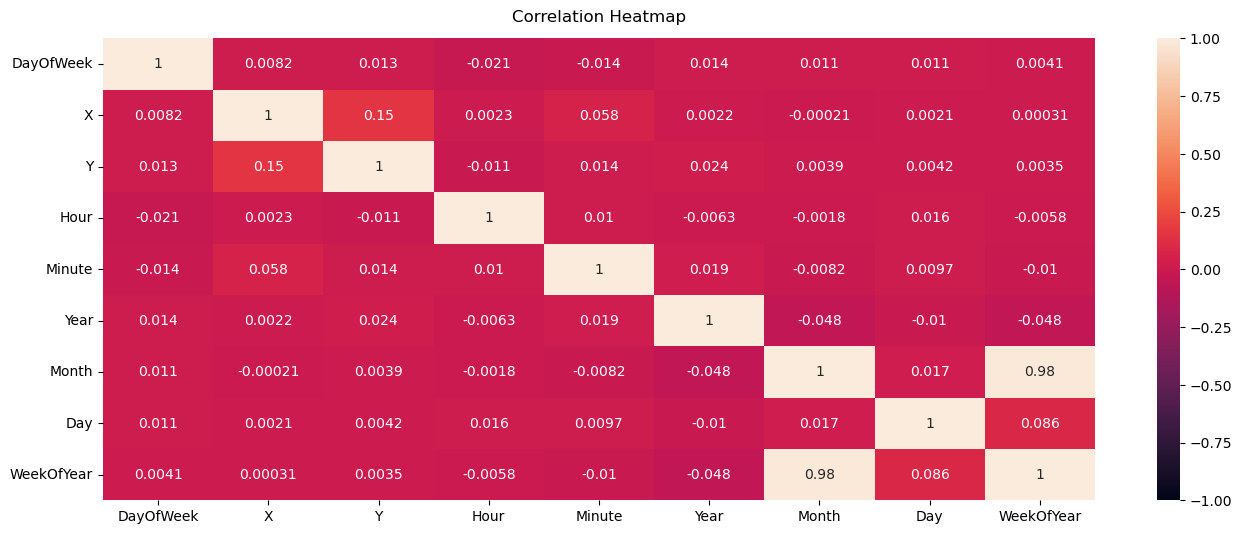

In [48]:
## Korrelationsanalyse Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.loc[:, ~train.columns.isin(['CrimeAtDayTime','IsWeekend','IsHoliday','RushHour'])].corr(), vmin=-1,vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [49]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

train_cat = train[['Category','PdDistrict','Resolution','CrimeAtDayTime','IsWeekend','IsHoliday','RushHour']]

Korrelationsanalyse von nominal kategorischen Merkmalen, ohne Addresse aufgrund des geringen Rams in Colab. 
Description und Category sind hoch korreliert, was jedoch nicht weiter verwunderlich ist. Der Rest ist unauffällig.

In [50]:
rows= []

for var1 in train_cat:
  col = []
  for var2 in train_cat :
    cramers =cramers_V(train_cat[var1], train_cat[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = train_cat.columns, index =train_cat.columns)



df

,Category,PdDistrict,Resolution,CrimeAtDayTime,IsWeekend,IsHoliday,RushHour
Category,1.00,0.02,0.09,0.02,0.00,0.00,0.00
PdDistrict,0.02,1.00,0.01,0.00,0.00,0.00,0.00
Resolution,0.09,0.01,1.00,0.00,0.00,0.00,0.00
CrimeAtDayTime,0.02,0.00,0.00,1.00,0.00,0.00,0.03
IsWeekend,0.00,0.00,0.00,0.00,1.00,0.01,0.00
IsHoliday,0.00,0.00,0.00,0.00,0.01,1.00,0.00
RushHour,0.00,0.00,0.00,0.03,0.00,0.00,1.00




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



<AxesSubplot: xlabel='Dates', ylabel='Density'>

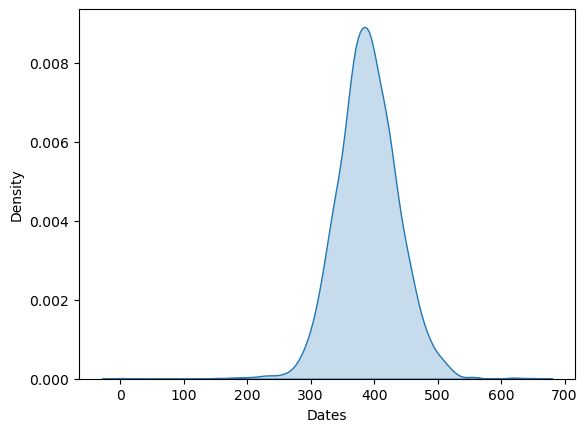

In [41]:
## Density Plot Anzahl Straftaten pro Tag
crimes_per_date = train.groupby('Date').count().iloc[:,0]
sns.kdeplot(data=crimes_per_date, shade=True)



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



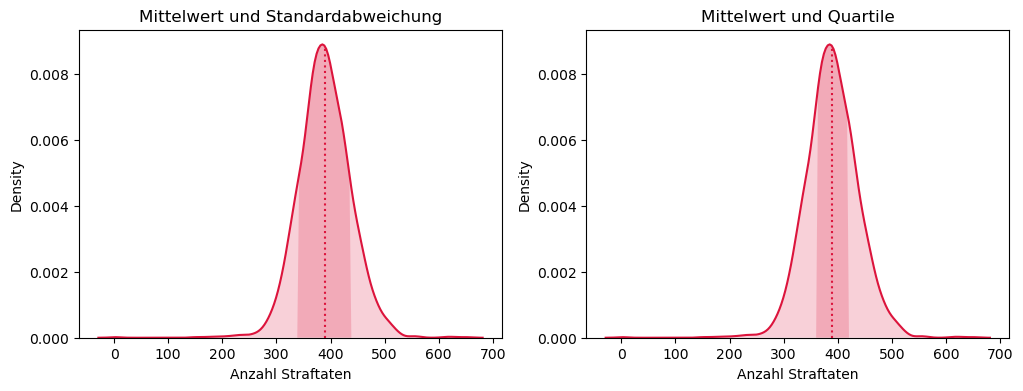

In [42]:
## Density Plot Anzahl Straftagen pro Tag mit Mittelwer, Standardabweichung und Qunatile
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for ax in axes:
    sns.kdeplot(crimes_per_date, shade=False, color='crimson', ax=ax)
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    if ax == axes[0]:
        middle = crimes_per_date.mean()
        sdev = crimes_per_date.std()
        left = middle - sdev
        right = middle + sdev
        ax.set_title('Mittelwert und Standardabweichung')
    else:
        left, middle, right = np.percentile(crimes_per_date, [25, 50, 75])
        ax.set_title('Mittelwert und Quartile')
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
    ax.set(xlabel='Anzahl Straftaten')
plt.show()
# Die Durchschnittliche Anzahl an Straftagen liegt bei ca. 400 pro Tag. 

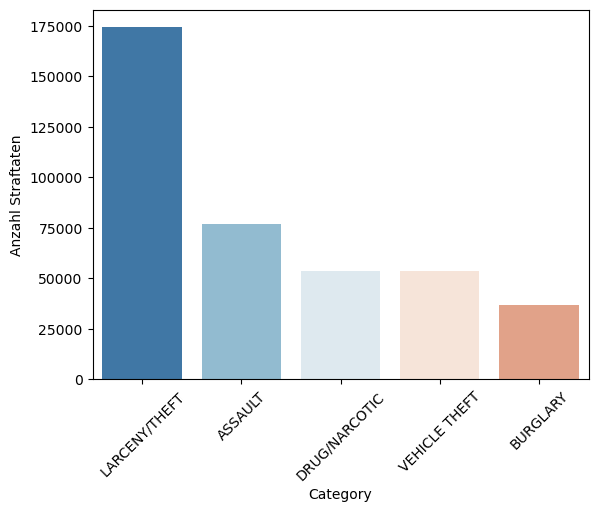

In [43]:
## Verteilung Straftaten
sns.set_palette('RdBu_r')
sns.countplot(x='Category',
              data=train_sub,
              order = train_sub['Category'].value_counts().index)
plt.ylabel('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

In [51]:
## Verteilung der Straftaten Relativ
cat_rel = train_sub.Category.value_counts(normalize=True)
cat_rel = cat_rel.mul(100)
cat_rel = cat_rel.rename('percent').reset_index()

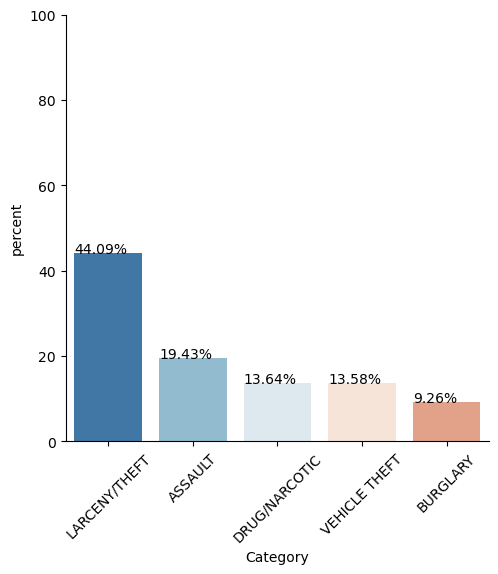

In [52]:
sns.set_palette('RdBu_r')
g = sns.catplot(x = 'index',
                y = 'percent',
                kind = 'bar',
                order = train_sub['Category'].value_counts().index,
                data = cat_rel)
g.ax.set_ylim(0,100)
g.set(xlabel = 'Category')
plt.xticks(rotation=45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [53]:
# Funktion zur Erzeugung gruppierter Plots mit relativem Anteil
def Grouped_Rel_Plot(group_by, split, length = 1):
    day_night = train_sub.groupby(group_by)[split].value_counts(normalize=True)
    day_night = day_night.mul(100)
    day_night = day_night.rename('percent').reset_index()
    
    sns.set_palette('RdBu_r')
    g = sns.catplot(x = group_by,
                    y = 'percent',
                    hue = split,
                    kind = 'bar',
                    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'] if (group_by == 'WeekdayName') else train_sub[group_by].value_counts().index,
                    aspect = length,
                    data = day_night)
    g.ax.set_ylim(0,100)
    g.set(xlabel = group_by)
    plt.xticks(rotation = 45)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

In [54]:
# Funktion zur Erzeugung gruppierter Plots mit relativem Anteil
def Grouped_Plot(group_by, length = 1):
    day_night = train_sub[group_by].value_counts(normalize=True)
    day_night = day_night.mul(100)
    day_night = day_night.rename('percent').reset_index()
    
    sns.set_palette('RdBu_r')
    g = sns.catplot(x = 'index',
                    y = 'percent',
                    kind = 'bar',
                    order = train_sub[group_by].value_counts().index,
                    aspect = length,
                    data = day_night)
    g.ax.set_ylim(0,100)
    g.set(xlabel = group_by)
    plt.xticks(rotation = 45)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

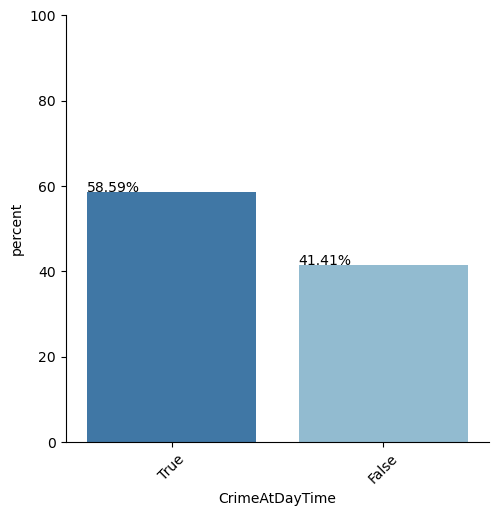

In [55]:
Grouped_Plot(group_by = 'CrimeAtDayTime', length=1)

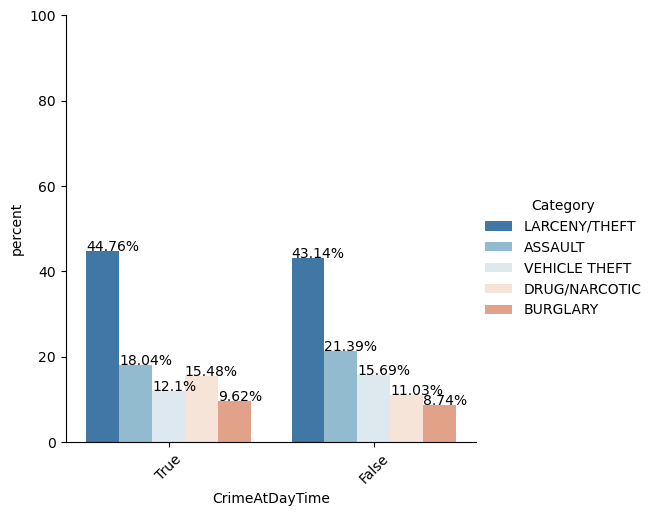

In [56]:
## Verteilung der Straftaten auf Tages- bzw. Nachtzeiten
Grouped_Rel_Plot(group_by = 'CrimeAtDayTime', split = 'Category')
# Überraschenderweise werden die meisten Straftaten am Tage durchgeführt bzw. erfasst.
# Auffällig: Wagendiebstahl fast ausgeglichen, Straftaten mit Drogen zu 2/3 am Tage

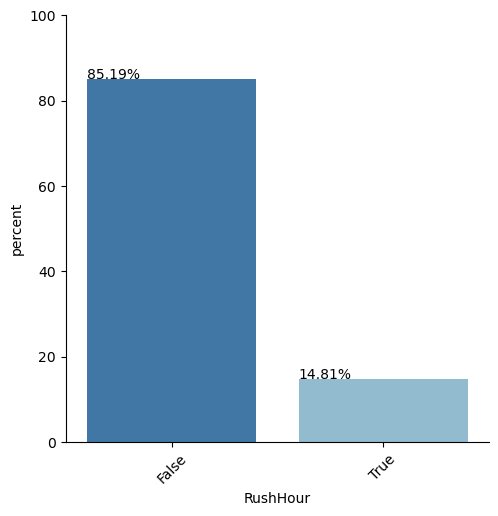

In [57]:
Grouped_Plot(group_by = 'RushHour', length=1)

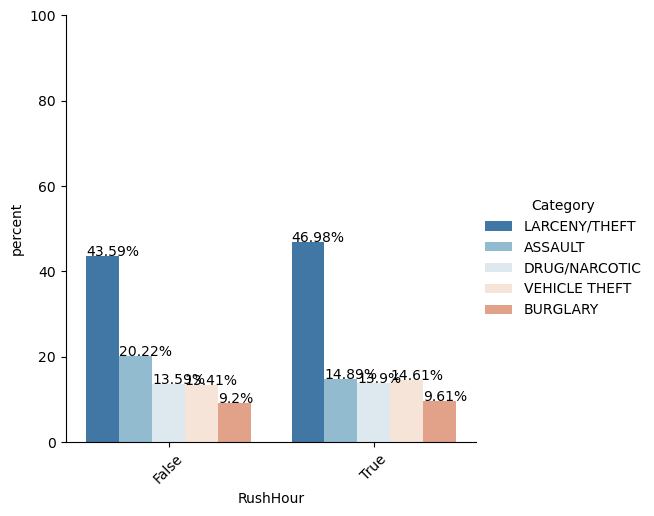

In [58]:
# Verteilung der Straftaten zu Stoßzeiten 
Grouped_Rel_Plot(group_by = 'RushHour', split = 'Category')
# Ausgeglichenheit über alle Straftatsarten bis auf Körperverletzung.

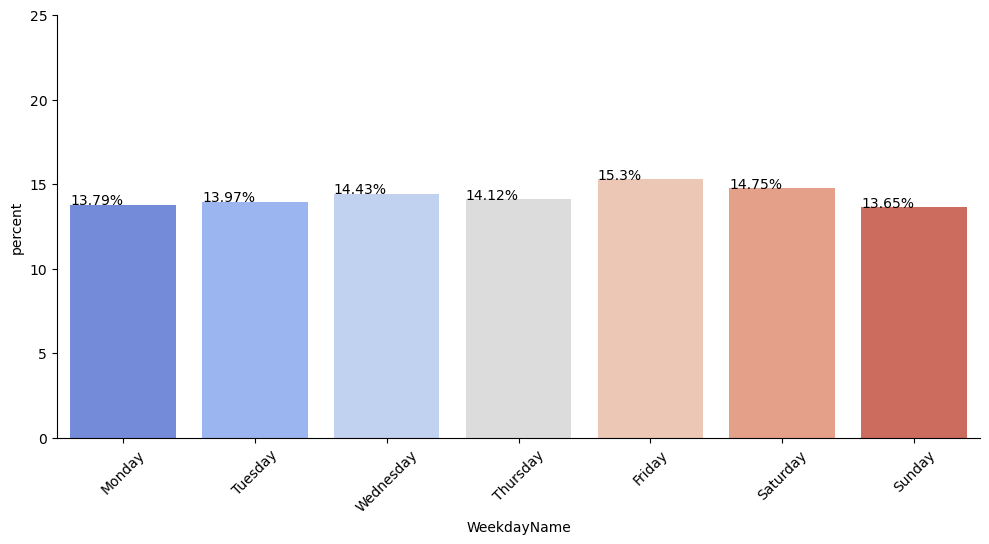

In [59]:
from matplotlib import cm
day_night = train_sub['WeekdayName'].value_counts(normalize=True)
day_night = day_night.mul(100)
day_night = day_night.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])
day_night = day_night.rename('percent').reset_index()

#sns.color_palette("rocket", as_cmap=True)
g = sns.catplot(x = 'index',
                y = 'percent',
                kind = 'bar',
                #order = train_sub['index'].value_counts().index,
                aspect = 2,
                palette=sns.color_palette('coolwarm', n_colors=7),
                data = day_night)
g.ax.set_ylim(0,25)
g.set(xlabel = 'WeekdayName')
plt.xticks(rotation = 45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

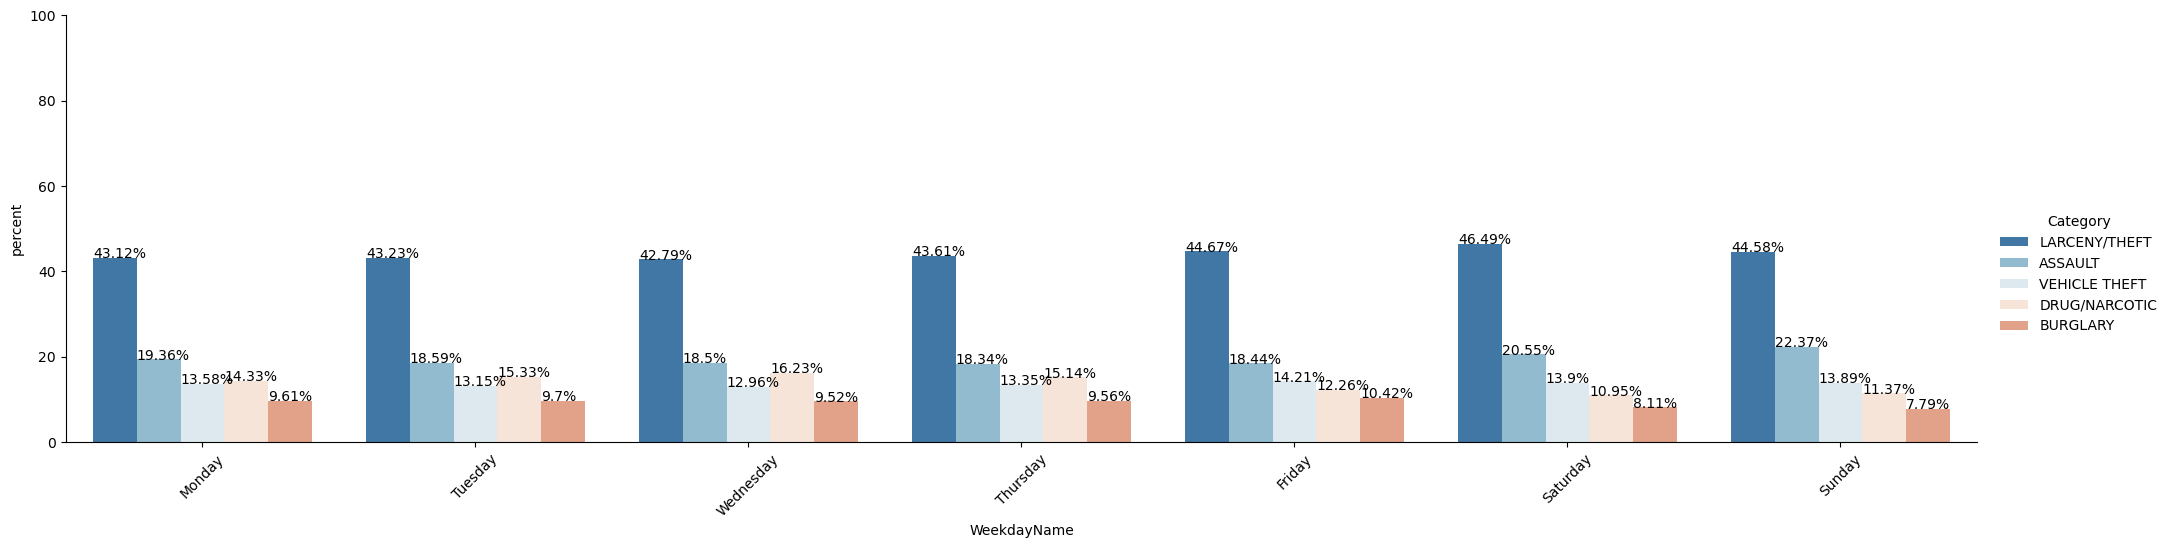

In [60]:
# Verteilung der Straftaten nach Tagen
Grouped_Rel_Plot(group_by = 'WeekdayName', split = 'Category',length=4)

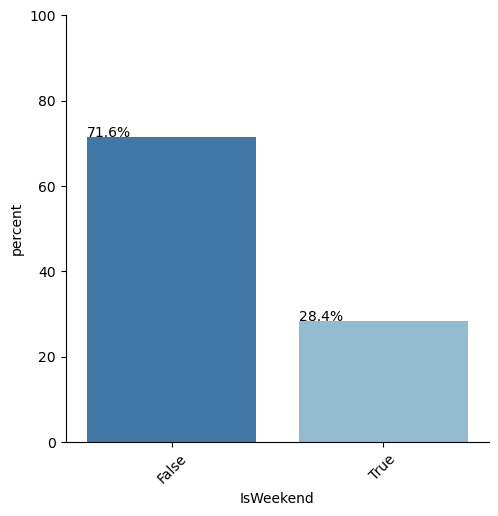

In [61]:
Grouped_Plot(group_by = 'IsWeekend', length=1)

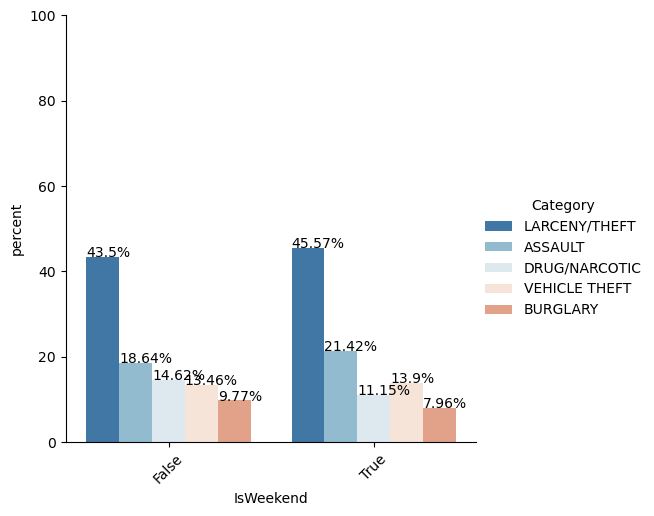

In [62]:
# Verteilung der Straftaten Werktags oder Wochenende
Grouped_Rel_Plot(group_by = 'IsWeekend', split = 'Category')
# Straftaten im Zusammenhang mit Diebstahl, Einbruch und Körperverletzung kommen häufiger am Wochende vor.
# Ggf. könnte der Freitag zum Wochende gezählt werden, würde das Ergebnis nochmals erheblich steigern.

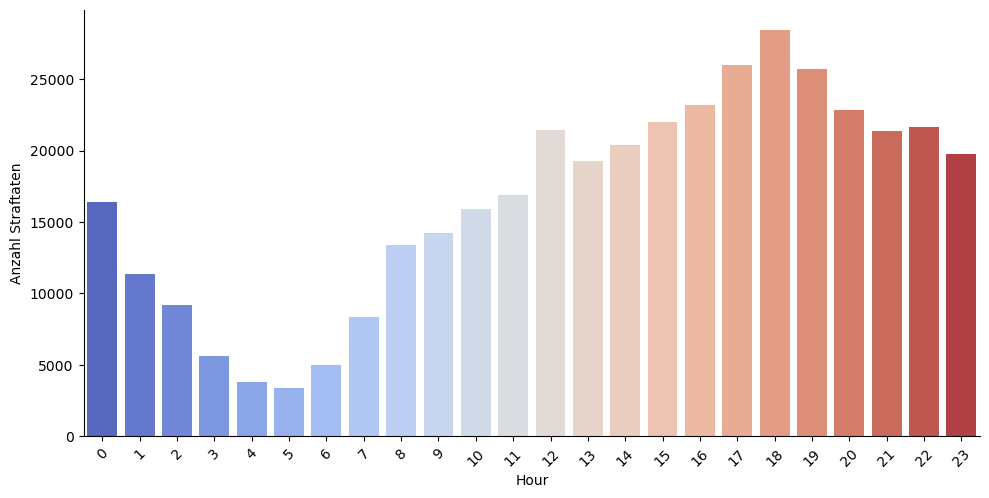

In [63]:
## Anzahl der Straftaten je Stunde
sns.set_palette('RdBu_r')
k = sns.catplot(x = 'Hour',
            data = train_sub,
                aspect = 2,
                palette=sns.color_palette('coolwarm', n_colors=24),
            kind = 'count')
k.set_ylabels('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()
# Auffälligkeit: Zu 12 und 18 Uhr sind wahrscheinlich ausreißer ersichtlich. Auch 22 Uhr übersteigt die Stunde davor.
# Ggf. liegt dort ein systematsicher Erfassungsfehler vor.

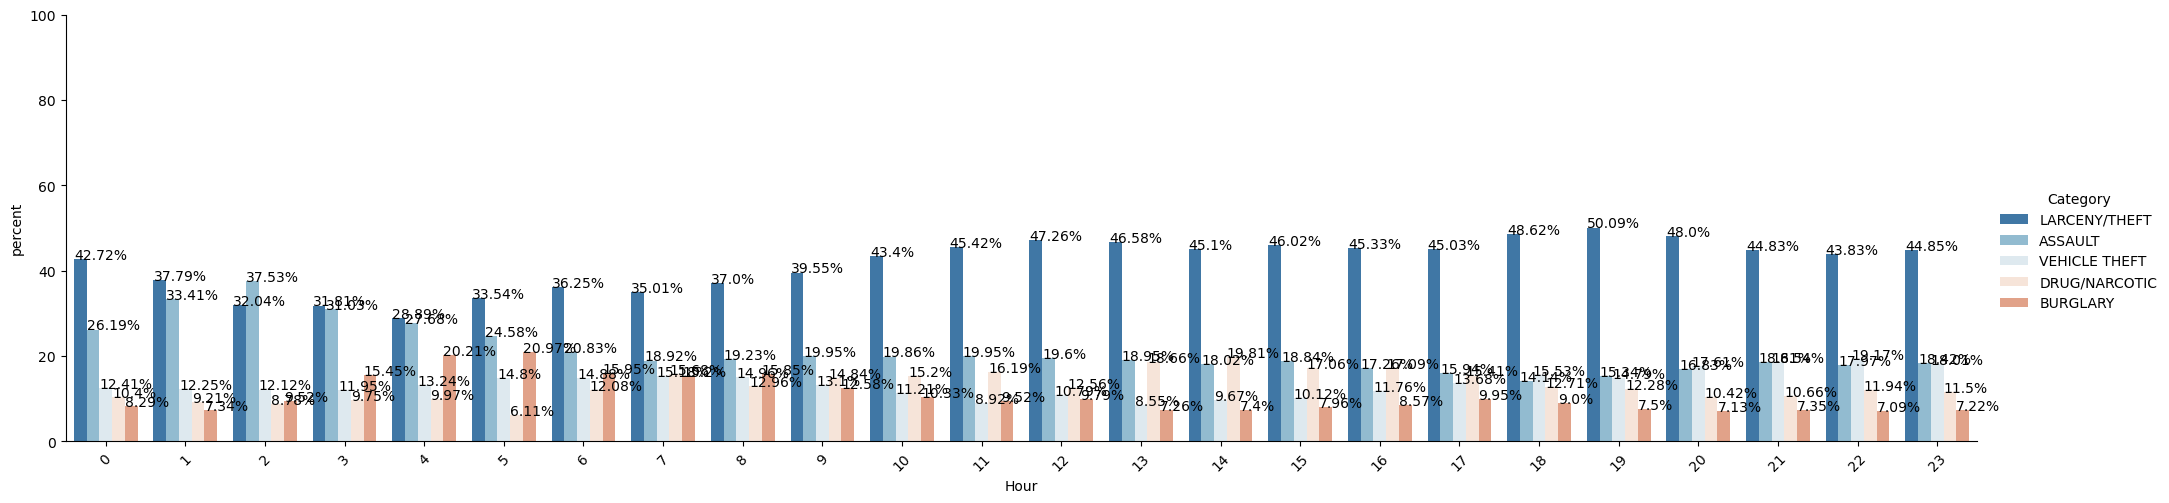

In [64]:
    day_night = train_sub.groupby('Hour')['Category'].value_counts(normalize=True)
    day_night = day_night.mul(100)
    day_night = day_night.rename('percent').reset_index()
    
    sns.set_palette('RdBu_r')
    g = sns.catplot(x = 'Hour',
                    y = 'percent',
                    hue = 'Category',
                    kind = 'bar',
                    aspect = 4,
                    data = day_night)
    g.ax.set_ylim(0,100)
    g.set(xlabel = 'Hour')
    plt.xticks(rotation = 45)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

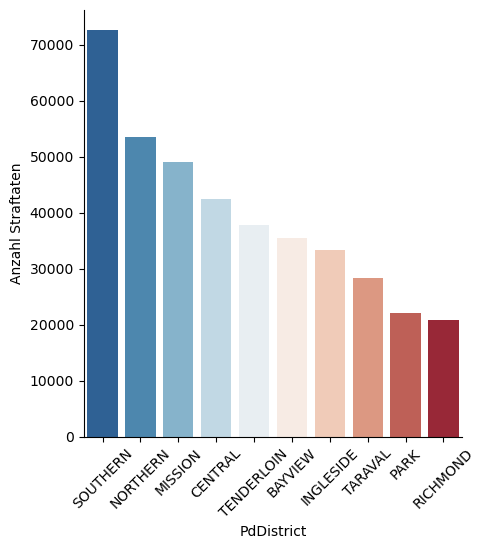

In [65]:
## Anzahl der Straftaten je Revier
k = sns.catplot(x = 'PdDistrict',
            data = train_sub,
            order = train_sub['PdDistrict'].value_counts().index,
            palette=sns.color_palette('RdBu_r', n_colors=10),
            kind = 'count')
k.set_ylabels('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

In [66]:
## Verteilung der Straftaten je Revier relativ
pddis_rel = train_sub.PdDistrict.value_counts(normalize=True)
pddis_rel = pddis_rel.mul(100)
pddis_rel = pddis_rel.rename('percent').reset_index()

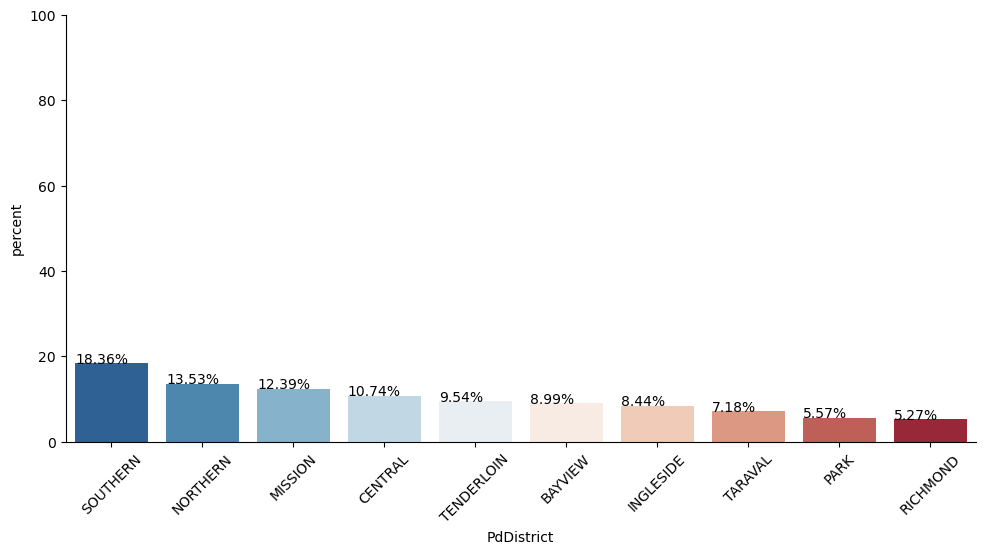

In [67]:
sns.color_palette('RdBu_r')
g = sns.catplot(x='index',
                y='percent',
                kind='bar',
                palette=sns.color_palette('RdBu_r', n_colors=10),
                data=pddis_rel,
                aspect=2)
g.ax.set_ylim(0,100)
g.set(xlabel='PdDistrict')
plt.xticks(rotation=45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    # Southern PdDistrict erfasst nahzu 1/5 der Straftaten, welche betrachtet werden sollen.

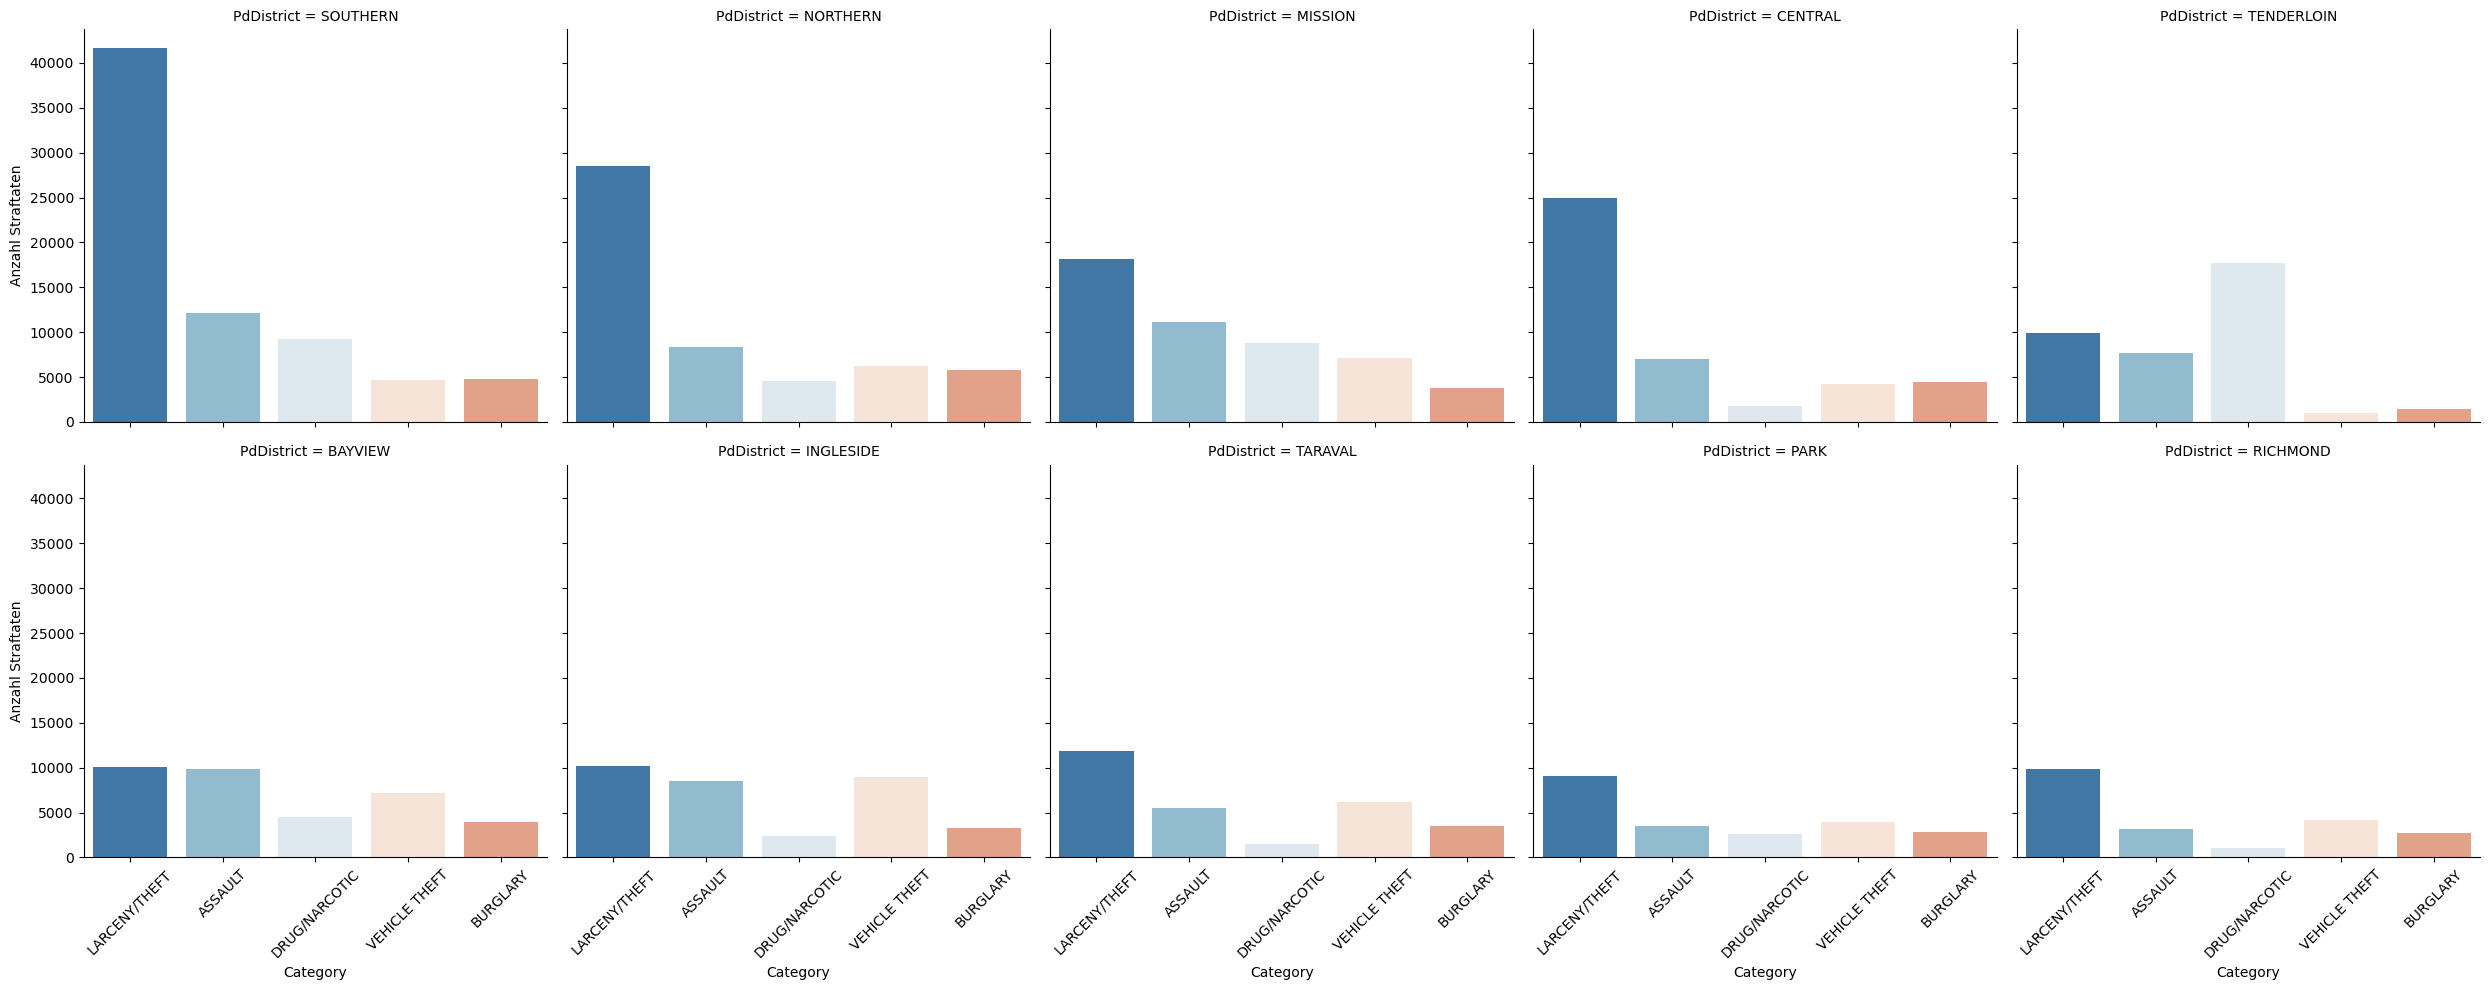

In [68]:
## Verteilung der Straftatsarten je Revier
g = sns.catplot(x='Category',
              data=train_sub,
            kind='count',
              order = train_sub['Category'].value_counts().index,
            col='PdDistrict',
            col_wrap=5,
            col_order=train_sub['PdDistrict'].value_counts().index)
g.set_ylabels('Anzahl Straftaten')
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
g.tight_layout()
plt.show()
# Auffälligkeiten: 
# 9 von 10 PdDistricts ist Diebstahl die häufigste Straftat
# Tenderloin ausreißer bei Straftaten mit Drogen

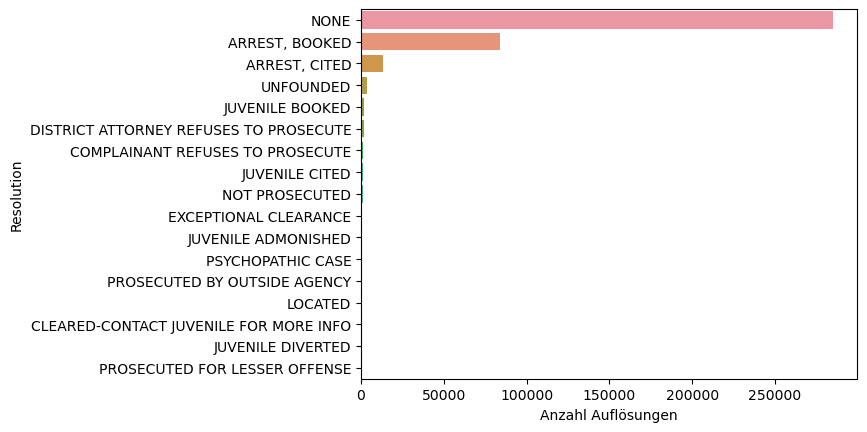

In [69]:
## Verteilung Auflösungen
sns.color_palette('RdBu_r')
sns.countplot(y='Resolution',
              data=train_sub,
              order = train_sub['Resolution'].value_counts().index)
plt.xlabel('Anzahl Auflösungen')
#plt.xticks(rotation=90)
plt.show()
# Dieses Merkmal kann ggf. entfernt werden, aufgrund der vielen NONE Einträge

In [70]:
## Zusammenführen der geringen Resolution Ausprägungen
top_res = train_sub.groupby(['Resolution']).size().reset_index(name='counts')
top_res = top_res.sort_values(by='counts',ascending=False)
top_res_names = top_res.iloc[0:4,0].tolist()
top_res_names

['NONE', 'ARREST, BOOKED', 'ARREST, CITED', 'UNFOUNDED']

In [71]:
## Alle Ausprägungen mit geringer Anzahl werden zusammengefasst
train_sub_red = train_sub
train_sub_red['Resolution'].mask(~train_sub_red['Resolution'].isin(top_res_names), 'OTHER', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
train_sub_red.groupby('Resolution').size()

Resolution
ARREST, BOOKED     83907
ARREST, CITED      13426
NONE              285260
OTHER               9155
UNFOUNDED           3612
dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'LARCENY/THEFT'),
  Text(1, 0, 'VEHICLE THEFT'),
  Text(2, 0, 'ASSAULT'),
  Text(3, 0, 'BURGLARY'),
  Text(4, 0, 'DRUG/NARCOTIC')])

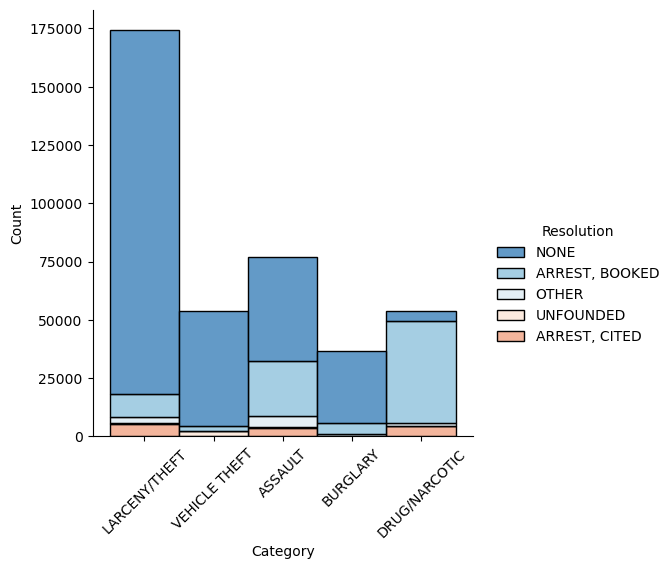

In [73]:
sns.color_palette('RdBu_r')
sns.displot(train_sub, x='Category', hue='Resolution', multiple='stack')
plt.xticks(rotation=45)
# Großteil der Straftaten werden nicht aufgelöst.
# Besonders Körperverletzung und Straftaten mit Drogen enden häufig in einer Verhaftung.